# Facebook Messages Parser and Analyzer

<b> Current Features for each Chat: </b>

<ul> 
<li> Create bar charts that contain the following information
<ul> 
    <li> Number of words you have exchanged in a thread </li> 
    <li> Sentiment scores over time for sentences said </li> 
</ul>
</ul>

## Libraries

In [1]:
import pylab as plt #makes the plots
import numpy as np
import pandas as pd
import time
import os
import nltk
import bisect
import datetime
import operator
from lxml import html
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from nltk import word_tokenize
import dateutil.parser as dateparser

import copy
import argparse

#plot the graphs in terminal
%matplotlib inline


## Global Variables

In [4]:
# number of conversations/html files you'd like to analyze
NUMBER_TO_ANALYZE = 3

# location of the html files
DIRECTORY = 'messages/'

I used Python 3 and Ipython 6 for this task, but got a few errors and needed so long to make the code work that I decided to write some of it anew from scratch / borrow from other places.

## Classes for Message Parsing

In [5]:
"""
    message_parser
    Enables parsing of messages from the Facebook HTML.
    modified from https://github.com/mjmeli/facebook-chat-word-cloud/blob/master/facebook_wordcloud/message_parser.py
    
"""

""" Unique message parser exception """
class MessageParserException(Exception):
    pass

""" Represents a message in the message thread """
class Message:
    # Each message has a sender, date, and a contents
    def __init__(self, sender, date, contents):
        self.sender = sender
        if not isinstance(date, datetime.date):
            self.date = dateparser.parse(date)
        else:
            self.date = date
        self.contents = contents

    # Comparison of two Messages relies on their date
    def __lt__(self, other):
        return self.date < other.date
    def __gt__(self, other):
        return self.date > other.date

    # String representation of a message
    def __repr__(self):
        date_str = self.date.strftime("%a %b %d, %Y %I:%M %p")
        return self.sender + " (" + date_str + "): " + self.contents

""" Represents a conversation thread. Thread = Conversation between a list of users since the beginning of time. """
class Thread:
    # Each thread has a list of users and a list of messages
    def __init__(self, users=None, messages=None):
        if users is None:
            self.users = set()
        else:
            self.users = set(users)
        if messages is None:
            self.messages = []
        else:
            for message in messages:
                if not any(message.sender == user for user in self.users):
                    raise ValueError
            self.messages = sorted(messages, key=lambda x: x.date, reverse=False)

    # Add a user to the conversation
    def add_user(self, user):
        self.users.add(user)

    # Add a list of users to the conversation
    def add_users(self, users):
        self.users.update(users)

    # Add a message to the conversation
    def add_message(self, message):
        if not any(message.sender == user for user in self.users):
            raise ValueError
        bisect.insort(self.messages, message)

    # Return message contents
    def get_messages_contents(self):
        return [message.contents for message in self.messages]

""" The message parser itself """
class MessageParser:
    # HTML should be sent in as a string
    def __init__(self, htmlstr):
        if not isinstance(htmlstr, str):
            raise ValueError
        self.html = html.fromstring(htmlstr)

    # Parse the HTML for a conversation thread
    # Can send in either one user or a list of users
    def parse_thread(self):
        
        # Create a new thread object
        thread = Thread()

        # Get all of the threads
        potential_threads = self.html.xpath("//div[@class='thread']")

        # There may be multiple threads in the conversation.
        threads_parsed = 0
        messages_added = 0
        messages_parsed = 0
        
        for potential_thread in potential_threads:
            
            # Track the number of threads_parsed
            threads_parsed = threads_parsed + 1

            # Get all of the message headers and message contents
            message_headers = potential_thread.xpath("div[@class='message']")
            message_contents = potential_thread.xpath("p")
            print("Found ", len(message_headers)," message(s) in thread ", threads_parsed)

            # Extract the information from the messages
            for i, header in enumerate(message_headers):
                messages_parsed = messages_parsed + 1
                try:
                    sending_user = header.xpath("div/span[@class='user']/text()[1]")[0]
                    # Add user to the thread
                    if not sending_user in thread.users:
                        thread.add_user(sending_user)
                    date = header.xpath("div/span[@class='meta']/text()[1]")[0]
                    contents = message_contents[i].xpath("text()")[0]

                    # Add a message to the thread
                    thread.add_message(Message(sending_user, date, contents))

                    messages_added = messages_added + 1
                except (AttributeError, IndexError):
                    # If the message is not a text message (i.e. picture), then
                    # the call to text() will throw this exception. Do not
                    # add this message as it contains no words.
                    continue

        # Print results
        print("RESULTS: Parsed ", threads_parsed, " thread(s) and ", messages_parsed, " message(s) for ", messages_added, " text message(s)") 

        # Return the parsed thread
        return thread

## Helper Functions

## Parsing

In [7]:
# a list of thread objects to be created
thread_list = []

# parse all files
for i in range(NUMBER_TO_ANALYZE):
    
    print("Loading file...")
    filename = os.path.join(DIRECTORY, str(i) + '.html')
    with open(filename, 'r') as f:
        messages_file_data = f.read()

    # Parse the HTML and extract messages (may take a long time)
    print("Building HTML tree...")
    message_parser = MessageParser(messages_file_data)
    print("Parsing messages...")
    thread = message_parser.parse_thread()
    thread_list.append(thread)

Loading file...
Building HTML tree...
Parsing messages...
Found  8954  message(s) in thread  1
RESULTS: Parsed  1  thread(s) and  8954  message(s) for  6073  text message(s)
Loading file...
Building HTML tree...
Parsing messages...
Found  15838  message(s) in thread  1
RESULTS: Parsed  1  thread(s) and  15838  message(s) for  14347  text message(s)
Loading file...
Building HTML tree...
Parsing messages...
Found  19865  message(s) in thread  1
RESULTS: Parsed  1  thread(s) and  19865  message(s) for  19421  text message(s)


## Functions for features to analyze

### Word_count

In [8]:
# A function returns the word count of a thread
def get_word_count(thread):
    print("Analyzing messages for word frequencies...")
    messages = thread.get_messages_contents() # list of message strings
    s = " "
    conversation = s.join(messages) # joins the list of strings to one continuous string of conversation
    tokens = word_tokenize(conversation) # split string into tokens
    text = nltk.Text(tokens) 
    return len(text)
    
# Returns a dictionary that associates users and their respective word count with you
def word_count_per_user(thread_list):
    dic = {}
    for thread in thread_list:
        user_s = ", ".join(thread.users)
        dic[user_s] = get_word_count(thread)
    return dic

### Sentiment Analysis

In [9]:
# return a(!) mean sentiment score, based on SentimentIntensityAnalyzer: 
# compound is an overall positive or negative score.
def mean_sid(messages, qualify='compound'):
    sid = SentimentIntensityAnalyzer()
    return np.mean([sid.polarity_scores(sentence)[qualify] for sentence in messages])

# creates the 4 different sentiment scores per sentence (neu = neutral, neg = negative, pos = positive, compound = overall)
def sentiment_over_time(messages):
    sid = SentimentIntensityAnalyzer()
    neg = np.array([sid.polarity_scores(sentence)['neg'] for sentence in messages])
    pos = np.array([sid.polarity_scores(sentence)['pos'] for sentence in messages])
    neu = np.array([sid.polarity_scores(sentence)['neu'] for sentence in messages])
    compound = np.array([sid.polarity_scores(sentence)['compound'] for sentence in messages])
    return neg, pos, neu, compound


## Analysis & Plotting

### Word_count

Analyzing messages for word frequencies...
Analyzing messages for word frequencies...
Analyzing messages for word frequencies...


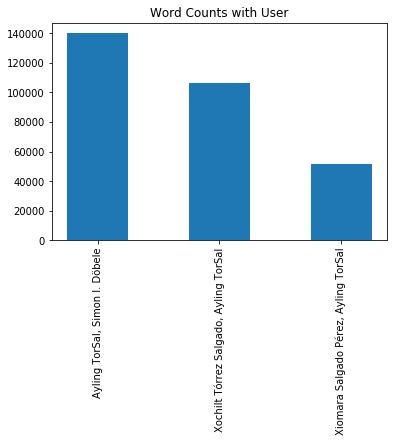

In [10]:
word_counts = word_count_per_user(thread_list)

# sorted_word_counts: a list of tuples sorted by the second element in each tuple, 
# i.e. the value of the dictionary. dict(sorted_x) == x.
sorted_word_counts = sorted(word_counts.items(), key=operator.itemgetter(1))
# sort from highest to lowest (i.e. reverse previous)
sorted_word_counts.sort(key=lambda x: x[1], reverse=True) 

# unpack a list of pairs into two tuples
users, word_count = zip(*sorted_word_counts)
X = np.arange(len(users))

plt.bar(X, word_count, align='center', width=0.5)
plt.xticks(X, users, rotation = 90)
plt.title('Word Counts with User')
plt.show()


### Sentiment Analysis - Timeseries of sentiments

In [17]:
# choose a thread
THREAD_TO_ANALYZE = 2
thread = thread_list[THREAD_TO_ANALYZE]

# list of messages
messages = thread.get_messages_contents()
# mean sentiment score with your chosen thread
mean_sid(messages)

np.random.randn(20,4)

array([[  2.83920285e-01,   1.04408311e+00,   1.14074155e+00,
          1.79316556e-01],
       [  3.07940932e-02,   1.45418011e+00,   7.15218610e-01,
         -5.53328134e-02],
       [  2.73153955e+00,  -4.51422074e-01,   1.81291386e-01,
         -1.21660294e-01],
       [  5.14802236e-01,  -5.48242574e-01,   6.11407814e-01,
         -5.62200260e-01],
       [ -1.24048665e+00,   4.74272780e-01,   4.91573804e-01,
          5.23259642e-01],
       [  4.38658254e-01,   7.25279523e-01,  -1.63789342e+00,
          4.48580619e-02],
       [  1.82554239e-01,   1.22521517e+00,  -5.29195345e-01,
         -1.20661575e+00],
       [  5.84586556e-01,  -1.06985748e-01,  -1.65847605e+00,
          2.43929350e+00],
       [  5.68115287e-01,  -8.90814887e-01,   2.24957330e-01,
         -1.68884834e-01],
       [ -7.03918451e-01,   6.29561480e-01,  -1.28574610e+00,
         -2.01413907e+00],
       [  5.98237130e-02,  -3.03884739e-01,   4.05739216e-01,
         -2.42097907e+00],
       [ -1.20571400e

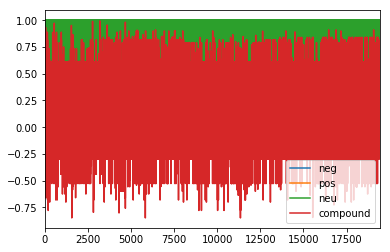

In [18]:
# Plot sentiment scores over time for your chosen thread
neg, pos, neu, compound = sentiment_over_time(messages)

data = {'neg' : pd.Series(neg),'pos' : pd.Series(pos), 'neu' : pd.Series(neu), 'compound' : pd.Series(compound)}
df = pd.DataFrame(data, columns = ['neg', 'pos', 'neu', 'compound'])

df.plot(kind='line')
